In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
plt.rcParams["font.family"] = "serif"
plt.rcParams["pdf.fonttype"] = 42
df = pd.read_csv("./parkinsons_updrs.data.csv")
df.describe()

,index,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,2937.000000,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,1696.110747,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,0.000000,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,1468.500000,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,2937.000000,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,4405.500000,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,5874.000000,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


In [2]:
df["difference"] = df["total_UPDRS"] - df["motor_UPDRS"]
#Remove features
df = df.drop("index", axis=1)
df = df.drop("subject#", axis=1)
df = df.drop("test_time", axis=1)
df = df.drop("total_UPDRS", axis=1)
df = df.drop("sex", axis=1)
df = df.drop("HNR", axis=1)
df = df.drop("Jitter:RAP", axis=1)
df = df.drop("Jitter(%)", axis=1)
df = df.drop("Jitter:PPQ5", axis=1)
df = df.drop("Jitter:DDP", axis=1)
df = df.drop("Shimmer:APQ3", axis=1)
df = df.drop("Shimmer:APQ5", axis=1)
df = df.drop("Shimmer(dB)", axis=1)
df = df.drop("Shimmer:DDA", axis=1)
df = df.drop("Shimmer", axis=1)
df = df.drop("NHR", axis=1)

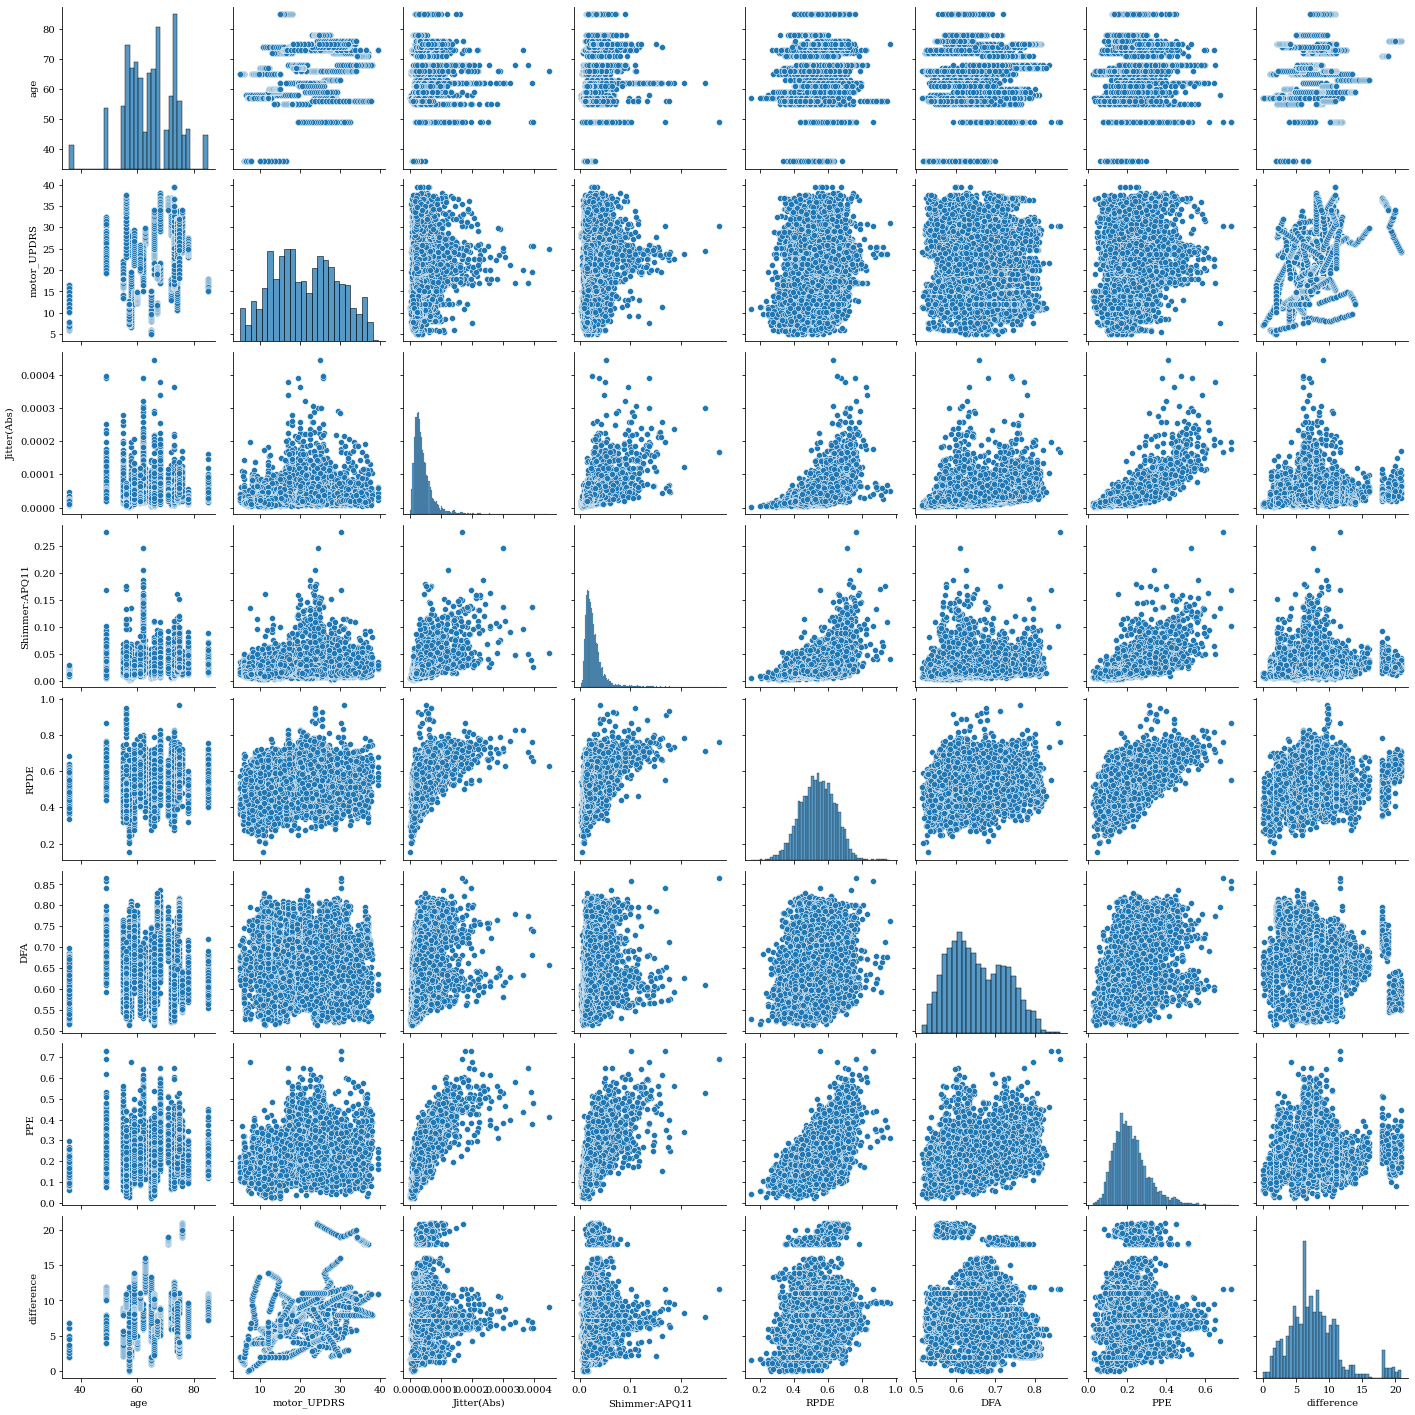

In [3]:
sns.pairplot(df);

In [3]:
# Convert target variable to binary variable
threshold = 30 # Define a threshold value for the target variable
df["motor"] = df["motor_UPDRS"].apply(lambda x: 1 if x >= threshold else 0)
df.drop("motor_UPDRS", axis=1, inplace=True)
#Y is the target
Y = df["motor"]
X = df.drop("motor", axis=1)

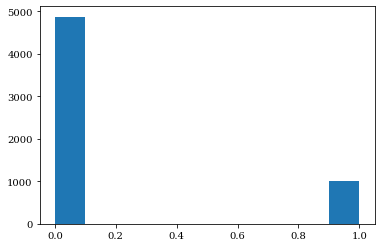

In [4]:
plt.hist(Y);

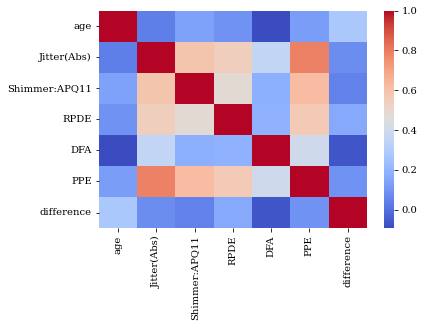

In [5]:
cor_matrix = X.corr()
sns.heatmap(cor_matrix, annot=False, cmap = "coolwarm");

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 15],
    'criterion': ['gini', 'entropy']
}

# Split the data into train, validation, and test sets
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=validation_ratio/(train_ratio+test_ratio))

model = RandomForestClassifier(oob_score=True)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
Y_pred_valid = best_model.predict(X_valid)
valid_accuracy = accuracy_score(Y_valid, Y_pred_valid)
print("Validation Accuracy:", valid_accuracy)

# Evaluate the best model on the test set
Y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print("Test Accuracy:", test_accuracy)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Validation Accuracy: 0.9682539682539683
Test Accuracy: 0.9625850340136054
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 500}


In [16]:
n_estimators = 500
max_depth = 15
criterion = "gini"

model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    oob_score=True,
    criterion=criterion)
model.fit(X_train,Y_train);

In [23]:
# Make predictions on the test set
Y_pred = model.predict(X_valid)
Y_train_proba = model.predict_proba(X_train)[:, 1] # Probability of positive class
Y_valid_proba = model.predict_proba(X_valid)[:, 1] # Probability of positive class

# Calculate evaluation metrics
accuracy = accuracy_score(Y_valid, Y_pred)
precision = precision_score(Y_valid, Y_pred, average="binary")
recall = recall_score(Y_valid, Y_pred, average="binary")
f1 = f1_score(Y_valid, Y_pred, average="binary")
train_auc = roc_auc_score(Y_train, Y_train_proba)
valid_auc = roc_auc_score(Y_valid, Y_valid_proba)
oob_score = model.oob_score_
oob_error = 1-model.oob_score_
conf_matrix = confusion_matrix(Y_valid, Y_pred)
cv_scores = cross_val_score(model, X, Y, cv=5)
rmse = mean_squared_error(Y_valid, Y_pred, squared=False) 
mae = mean_absolute_error(Y_valid, Y_pred)
#Print the evaluation metrics
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1))
print("RMSE: {:.3f}".format(rmse))
print("MAE: {:.3f}".format(mae))
print("Train AUC: {:.3f}".format(train_auc))
print("Valid AUC: {:.3f}".format(test_auc))
print("OOB Score: {:.3f}".format(oob_score))
print("OOB Error: {:.3f}".format(oob_error))
print('Mean CV score: {:.3f}'.format(cv_scores.mean()))
print("Confusion matrix:\n", conf_matrix)

Accuracy: 0.965
Precision: 0.911
Recall: 0.881
F1-Score: 0.896
RMSE: 0.187
MAE: 0.035
Train AUC: 1.000
Valid AUC: 0.993
OOB Score: 0.963
OOB Error: 0.037
Mean CV score: 0.758
Confusion matrix:
 [[718  13]
 [ 18 133]]


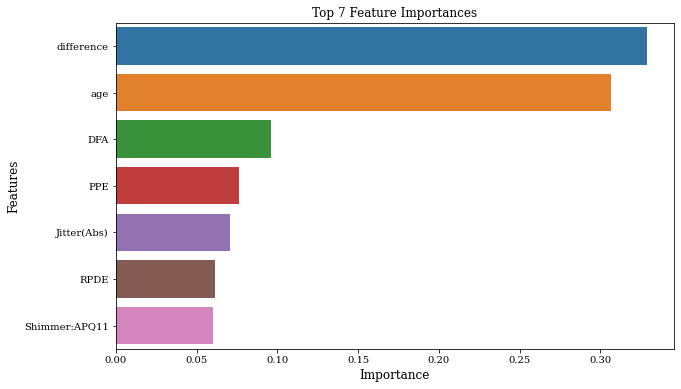

In [24]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[:8], y=feature_importances[:10].index)
plt.title("Top 7 Feature Importances", fontsize=12)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

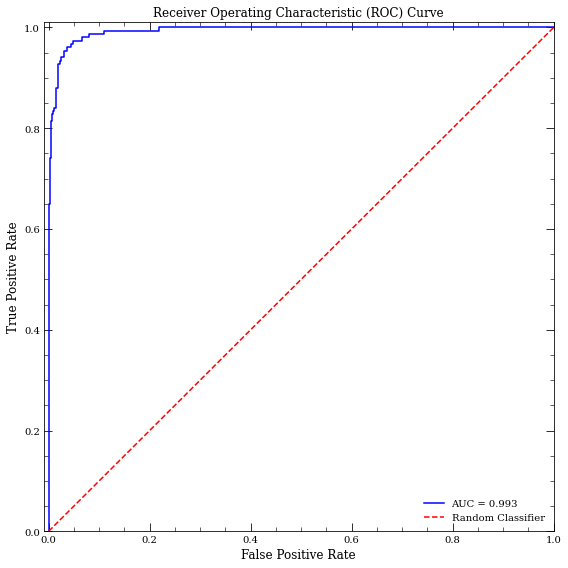

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
# Compute the false positive rate, true positive rate, and threshold values required for plotting the ROC curve
fpr, tpr, thresholds = roc_curve(Y_valid, Y_valid_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(test_auc), color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color="red")
plt.xlabel('False Positive Rate', fontsize=12)

ax.minorticks_on()
ax.xaxis.set_ticks_position("both")
ax.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
ax.tick_params(top=True, right=True, which='minor', direction='in', length=4)
ax.set_ylim(0,1.01)
ax.set_xlim(-0.01,1)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
plt.legend(loc="lower right", frameon=False)
fig.tight_layout()
plt.savefig('roc.png')
plt.show();